# Setup

In [1]:
backend_name = 'ibmq_quito'

In [2]:
import icepp
import csv
import math
from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN

from sample.onestepSim_LBNL import runQuantum as step_1
from sample.twostepSim_LBNL import runQuantum as step_2
from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit
from pytket.extensions.qiskit import IBMQBackend, AerStateBackend, AerBackend

from qiskit import *
from qiskit.visualization import plot_histogram
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo',group='internal',project='icepp')

backend = provider.get_backend(backend_name)
sim_b = AerBackend() #全結合
dev_b = IBMQBackend(backend_name=backend_name, hub='ibm-q-utokyo',group='internal',project='icepp') #本物の実機

# Benchmarks

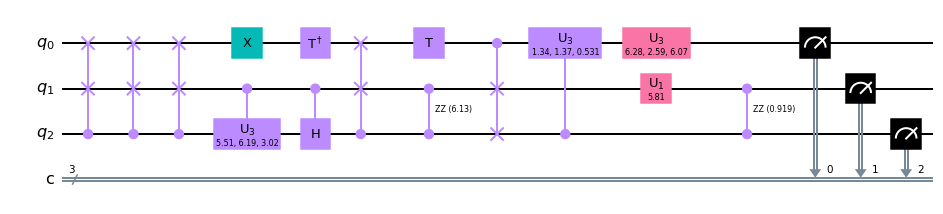

In [3]:
from qiskit.circuit.random import random_circuit

test = random_circuit(3, 10, measure=True)

test.draw("mpl")

# Transpile and Experiment Run

In [4]:
transpiled_qcs = icepp.transpiler(test,backend,dev_b,level=3).transpile()

In [5]:
transpiled_qcs.count_ops()

OrderedDict([('rz', 85), ('sx', 62), ('cx', 32), ('measure', 3)])

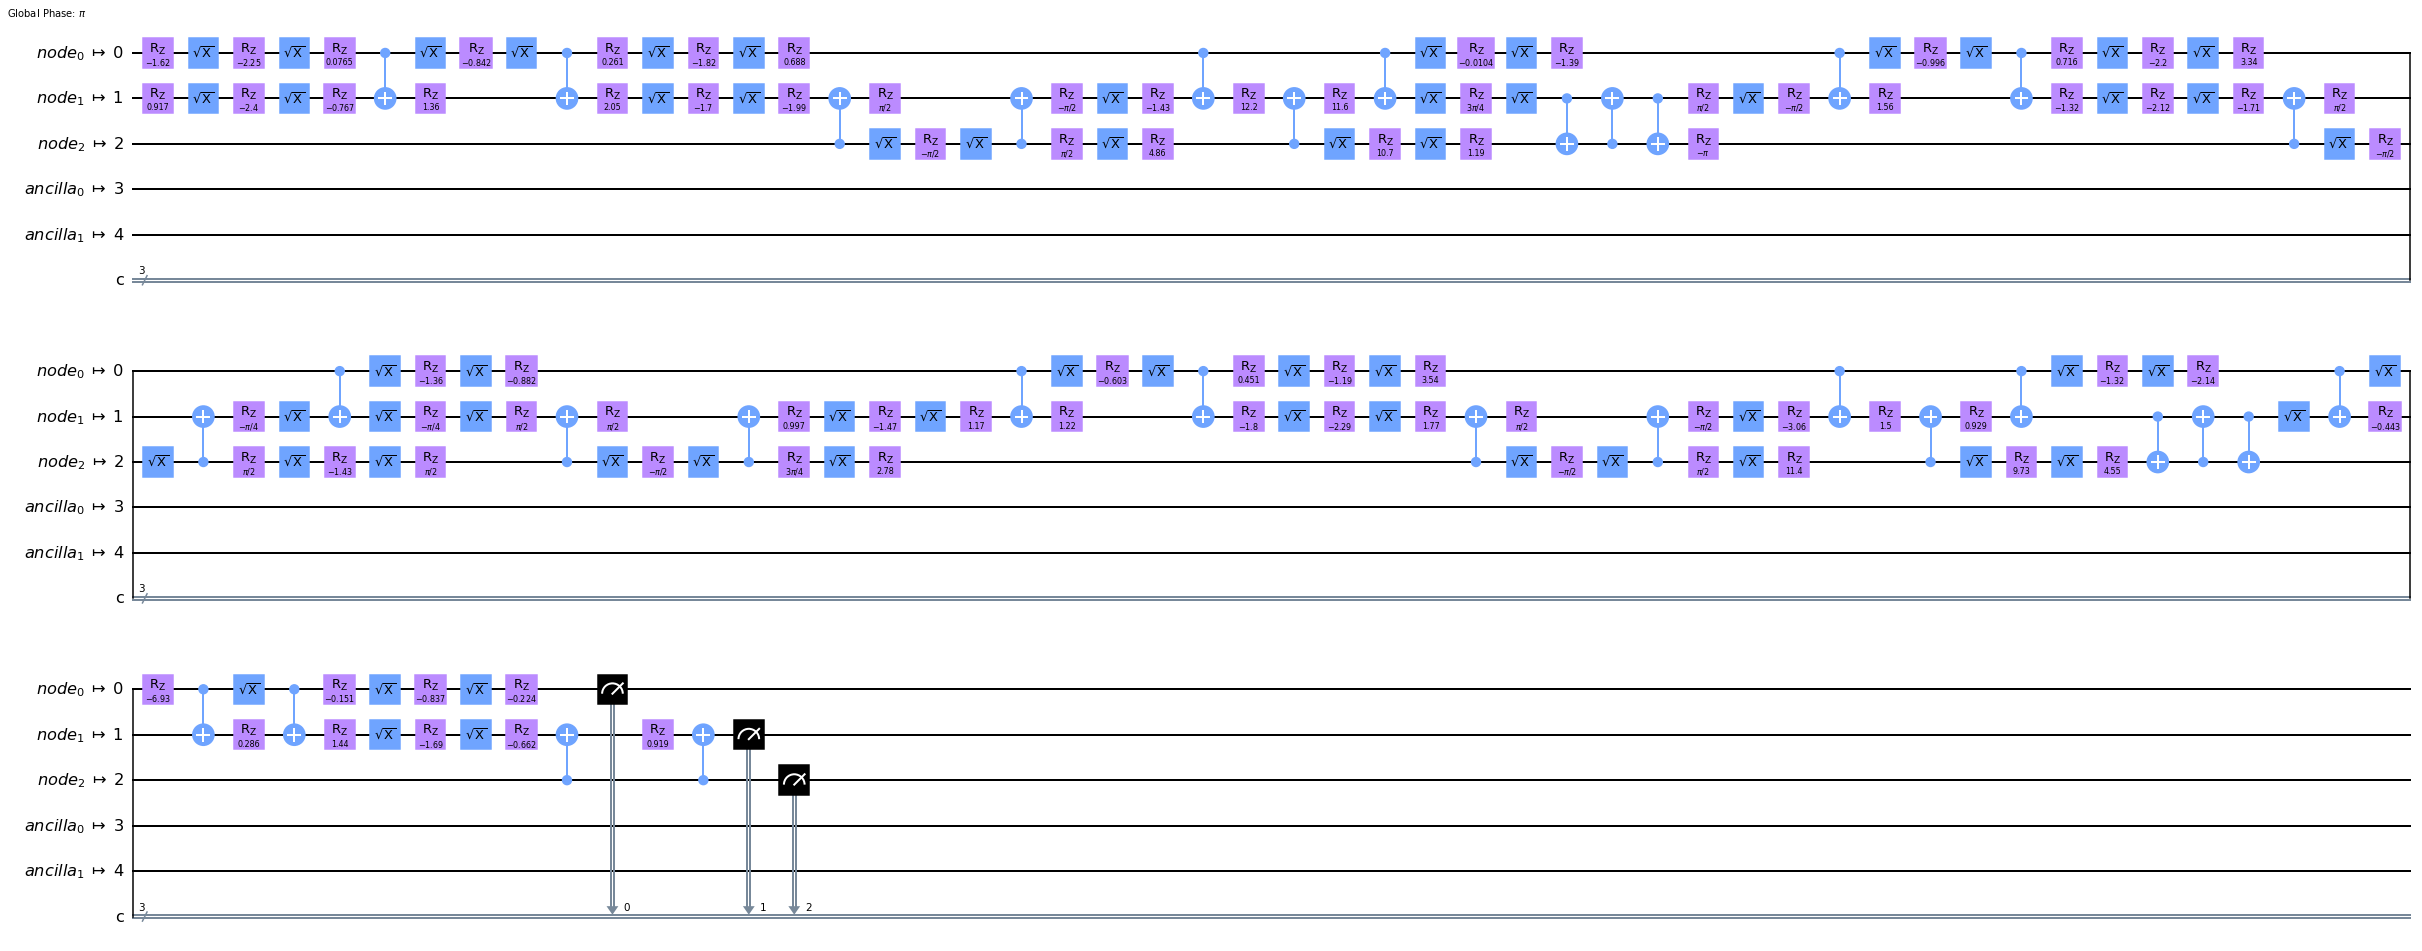

In [6]:
transpiled_qcs.draw('mpl',fold=50) 

In [8]:
results = icepp.qc_experiment(qc_list=[transpiled_qcs], backend=backend, shots=1024).run()

Job id : 4d4ca25718344373aac1d7db6e3e3115-1648989779712169
Job Status: job has successfully run


In [9]:
results.get_counts(0)

{'000': 75,
 '001': 678,
 '010': 33,
 '011': 87,
 '100': 23,
 '101': 38,
 '110': 26,
 '111': 64}

# Simulator

In [10]:
simulation_counts = icepp.simulator(test).aer_simulator(shots=1024)
print(simulation_counts)

{'001': 1024}


In [11]:
icepp.simulator(test).statevector_simulator(output='statevector')

Statevector([ 2.78561202e-03-1.90657868e-03j,
             -4.04693718e-01+9.14446062e-01j,
             -0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              2.09363228e-35+6.38455022e-33j,
              2.82751641e-33-4.16260295e-33j,
              7.37758561e-18-7.51517821e-17j,
             -3.82419505e-17+4.56048006e-17j],
            dims=(2, 2, 2))


In [12]:
icepp.simulator(test).statevector_simulator(output='probabilities_distribution')

{'000': 1.1394676611596132e-05, '001': 0.9999886053233884}

# Meausrement Error Mitigation

※The number of measurements and clibits must be identical.
<br>
When you want to do mitigate measurement error, then do not use "icepp.qc_experiment" twice for raw experiment and mitigation experiment inidividually bacause that cost twice times. In "icepp.MeasurementErrorMitigation_demo", those two jobs are merged.

In [13]:
info_list = icepp.MeasurementErrorMitigation_demo(backend).measured_qubits(transpiled_qcs)

In [14]:
meas_mit_results = icepp.MeasurementErrorMitigation_demo(backend).apply([transpiled_qcs], info_list, shots=1024)

Job id : 5ef6857ccd754b2191fdbaeda0c159fb-1648989925458133
Job Status: job has successfully run


In [15]:
raw_counts = meas_mit_results[0].get_counts(0)
meas_mit_counts = meas_mit_results[1].get_counts(0)

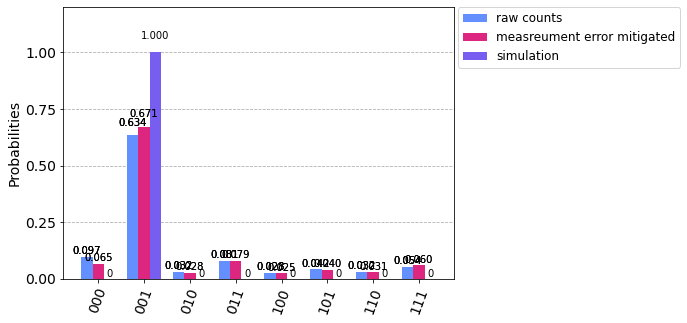

In [18]:
legend = ['raw counts','measreument error mitigated','simulation']
plot_histogram([raw_counts, meas_mit_counts, simulation_counts], legend=legend)

# CNOT Error Mitigation

In [20]:
qc_3cx = icepp.zne(1,transpiled_qcs).fiim_generate_circs()

In [21]:
cnot_mit_results = icepp.qc_experiment(qc_list=[qc_3cx], backend=backend, shots=1024).run()

Job id : a9bd5efefa7c42edb8642f8f6cf3c198-1648990002713964
Job Status: job has successfully run


In [22]:
qc_3cx_counts = cnot_mit_results.get_counts(0)
cnot_mit_counts = icepp.zne(1,transpiled_qcs).apply(raw_counts, qc_3cx_counts)

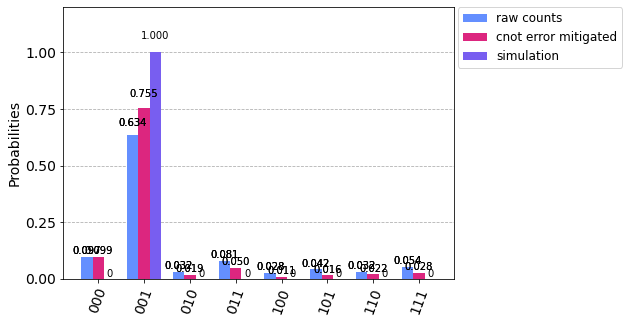

In [23]:
legend = ['raw counts','cnot error mitigated','simulation']
plot_histogram([raw_counts, cnot_mit_counts, simulation_counts], legend=legend)

# Raw + Measurment error mitigation + CNOT error mitigation in 1 job

In [28]:
all_mitigated_counts = icepp.pass_manager(transpiled_qcs, level=1, backend=backend, shots=1024, zne='on').auto_manager()

Job id : f2f8e48be85a43bbaff5801151d2cbc3-1648990137864306
Job Status: job has successfully run
Raw counts: {'000': 85, '001': 680, '010': 41, '011': 83, '100': 28, '101': 28, '110': 31, '111': 48}
Measurement error mitigated counts {'000': 51.2180613182025, '001': 724.0410204086114, '010': 35.95639067998445, '011': 80.81014084528036, '100': 26.38176404232321, '101': 19.82074928935879, '110': 29.961665784551244, '111': 55.81020763168815}
CNOT error mitigated counts {'000': 32.512950179296006, '001': 889.7689807913678, '010': 21.869992911701623, '011': 36.656943440832336, '100': 7.745009559926146, '101': -9.830288241524698, '110': 11.84978515451079, '111': 33.42662620389019}


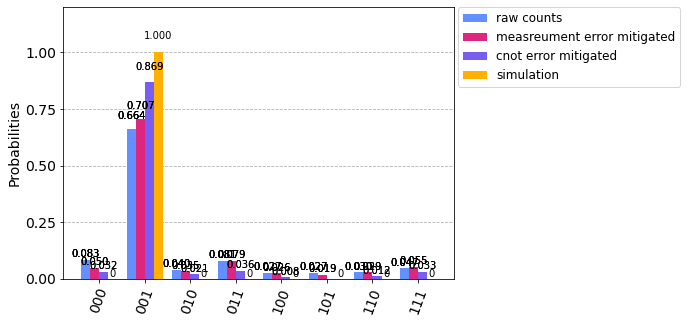

In [29]:
raw_counts, meas_mit_counts, cnot_mit_counts = all_mitigated_counts[0], all_mitigated_counts[1], all_mitigated_counts[2]

legend = ['raw counts','measreument error mitigated','cnot error mitigated','simulation']
plot_histogram([raw_counts, meas_mit_counts, cnot_mit_counts, simulation_counts], legend=legend)

In [31]:
import math

def fidelity(count1,count2,shots):
    fidelity=0
    for key in count1.keys():
        if (key in count2) and (count1[key] >0) and (count2[key] >0):
            fidelity += math.sqrt((count1[key]*count2[key]))/shots
    return fidelity

def all_fidelities(sim_counts, counts_list, shots):
    fidelity_list = []
    for counts in counts_list:
        each_fidelity = fidelity(sim_counts, counts ,shots)
        fidelity_list.append(each_fidelity)
    return fidelity_list

In [32]:
all_fidelities(sim_counts=simulation_counts, counts_list=all_mitigated_counts, shots=1024)

[0.8149003006503311, 0.8408753230965841, 0.9321561136977379]